# Задание

В файле `data.csv` представлены подневные данные объема расчетных счетов физических лиц. В отличие от депозита, клиент может снять всю сумму с расчетного счета в любой момент времени без каких-либо «штрафов». Такой продукт называют `Undefined Maturity Product – UMP`. Однако маловероятно, что все клиенты разом закроют свои счета в Банке. Всегда кто-то снимает деньги, а кто-то пополняет счет – есть некоторый стабильный уровень, ниже которого не опустится суммарный обьем расчетных счетов.

Например, если бы мы знали будущее объема расчетных счетов, как на рисунке 1, то стабильная часть на 1 месяц (1м) была бы на уровне, обозначенным красным цветом. Это тот уровень, который не пробивается на протяжении 1 месяца. Аналогично 2м – зеленый, 3м – синий, 4м – розовый.

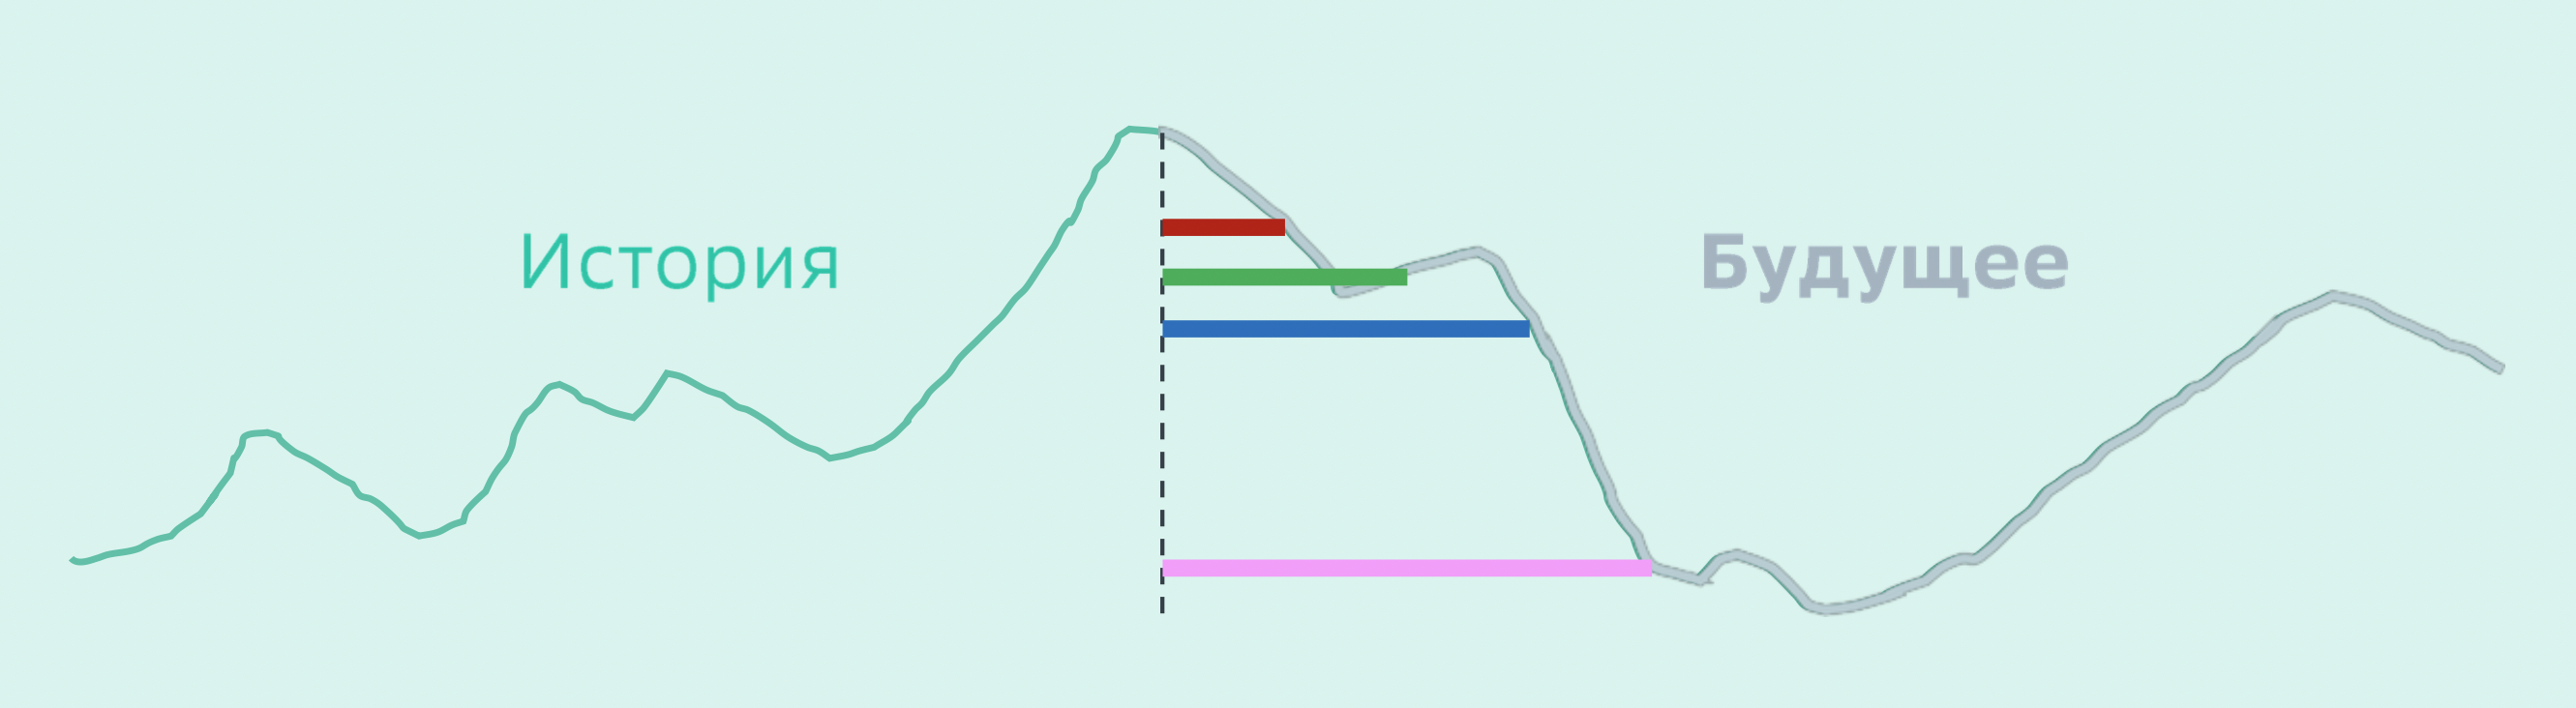

In [1]:
from IPython.display import Image
Image("Рисунок 1.png")

Для временного ряда в файле `data.csv` необходимо построить модель, которая оценивает обьем стабильной части средств на дату. 

**Например**:

model_forecast

(2019-02-01, ‘1М’, История_до_2019-02-01) = стабильная часть на 1М

**Возможные горизонты**: 1М, 2М, 3М, 4М, 5М, 6М, 7М, 8М, 9М, 10М, 11М, 12М

Критерии качества модели:

Нужно одновременно минимизировать величины:

- максимальный объем пробития стабильный части на валидационной выборке 
- фактическая стабильная часть – модельная стабильная часть 

Можно применять любые подходы. Как вариант: построить квантильную регрессию для прогнозирования ряда.

## Библиотеки

Импортируем всё, что понадобится в решении

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pmdarima as pm

from datetime import datetime
from dateutil.relativedelta import *
from dateutil import parser

import re

import warnings
warnings.filterwarnings('ignore')

## Предобработка данных

In [3]:
data = pd.read_csv('data.csv', sep=';')

data.head()

,REPORTDATE,VALUE
0,30.12.2013,3457625638
1,31.12.2013,3417092149
2,01.01.2014,3417092149
3,02.01.2014,3417092149
4,03.01.2014,3417092149


Посмотрим на общую информацию о данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   REPORTDATE  2111 non-null   object
 1   VALUE       2111 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 33.1+ KB


Можно заметить, что:
- в данных нет пропусков;
- даты не приведены к формату `datetime` (исправим это);

In [5]:
data['REPORTDATE'] = data['REPORTDATE'].apply(lambda x: x.replace('.', '/'))
data['REPORTDATE'] = pd.to_datetime(data['REPORTDATE'], dayfirst=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   REPORTDATE  2111 non-null   datetime64[ns]
 1   VALUE       2111 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 33.1 KB


Чтобы не работать с огромными числами, переведём колонку `VALUE` в значения в миллиардах

In [6]:
data['VALUE'] = data['VALUE'] * 10 ** (-9)

В рамках поставленной задачи данные можно сгруппировать по месяцам, взяв в качестве агрегирующей функции, моделирующей стабильную часть объема расчетных счетов, 0.05 квантиль колонки `VALUE`. 

Подневные данные сохраним в переменную `daily_data` для дальнейшей визуализации результатов модели.

In [7]:
def get_quantile(array):
    return np.quantile(array, 0.05)

data = data.set_index('REPORTDATE')

daily_data = data.copy()

data = data.resample('MS').apply(get_quantile)

data.reset_index(inplace=True)

Посмотрим на полученный временной ряд

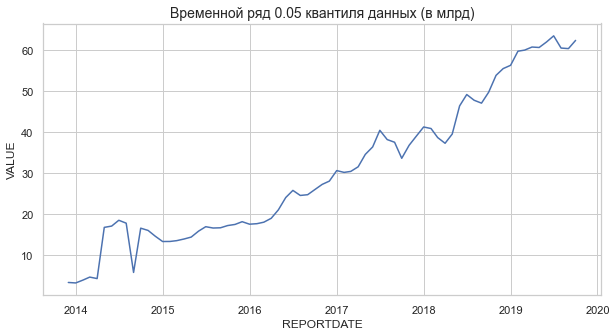

In [8]:
sns.set()
sns.set_style("whitegrid")

fig = plt.figure()
fig.set_size_inches(10, 5)

sns.lineplot(data['REPORTDATE'], data['VALUE'])

plt.title('Временной ряд 0.05 квантиля данных (в млрд)', fontsize=14)
plt.show()

## Разведочный анализ данных (EDA)

Посмотрим на распределение данных по годам и месяцам, для этого создадим соответствующие колонки

In [9]:
data['MONTH'] = data['REPORTDATE'].dt.month
data['YEAR'] = data['REPORTDATE'].dt.year

data.head()

,REPORTDATE,VALUE,MONTH,YEAR
0,2013-12-01,3.419119,12,2013
1,2014-01-01,3.303340,1,2014
2,2014-02-01,4.009738,2,2014
3,2014-03-01,4.727410,3,2014
4,2014-04-01,4.363643,4,2014


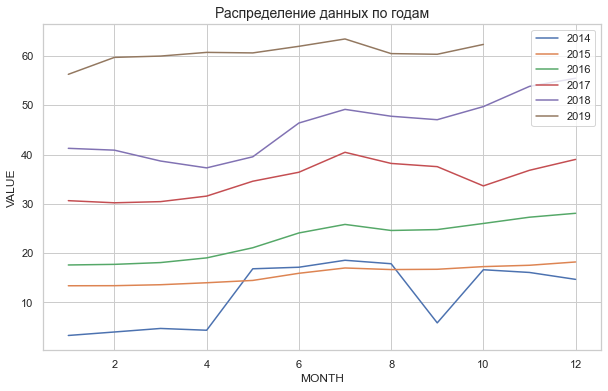

In [10]:
fig = plt.figure()
fig.set_size_inches(10, 6)

for year in data['YEAR'].unique():
    if year == 2013:
        continue # в 2013 году всего 1 значение, которое не будет видно на графике
        
    df_year = data[data['REPORTDATE'].dt.year == year]

    plt.plot('MONTH', 'VALUE', data=df_year, label=year)

plt.title('Распределение данных по годам', fontsize=14)
plt.xlabel('MONTH')
plt.ylabel('VALUE')
plt.legend()
plt.show()

Из полученного графика видно, что у рассматриваемого ряда явно выраженный положительный тренд (среднее значение растёт с каждым годом). Кроме того, каждый год заметен небольшой рост объема расчетных средств в летние месяцы. Из общей картины выбивается 2014 год, в который заметны резкие скачки значений.

Более подробно эти тенденции можно увидеть с помощью диаграмм размаха ("ящики с усами", box plot).

Text(0.5, 1.0, 'Диаграмма размаха по месяцам')

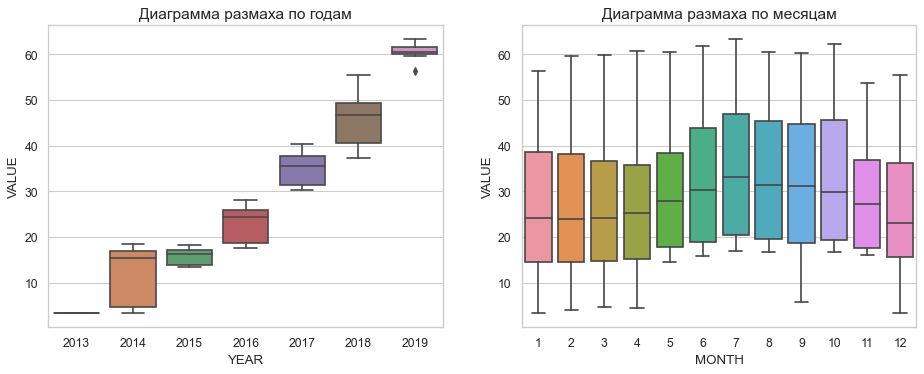

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi= 80)

sns.boxplot(x='YEAR', y='VALUE', data=data, ax=axes[0])
sns.boxplot(x='MONTH', y='VALUE', data=data, ax=axes[1])

axes[0].set_title('Диаграмма размаха по годам', fontsize=14); 
axes[1].set_title('Диаграмма размаха по месяцам', fontsize=14)

Из диаграммы размаха по годам очевиден общий тренд роста медианы, а также заметно, что ящики имеют разную ширину.

Из диаграммы по месяцам видно, что медианы распределены неравномерно в течение года и заметен рост в летние месяцы, отмеченный выше.

## Разделение на тренировочную и тестовую выборку

В качестве тестовой выборки возьмём данные за 2019 год, остальные отправим в тренировочную

In [12]:
train_data = data[data['YEAR'] != 2019]
test_data = data[data['YEAR'] == 2019]

train_data = train_data.set_index('REPORTDATE')
test_data = test_data.set_index('REPORTDATE')

## Анализ временного ряда

Воспользуемся функцией `seasonal_decompose` из `statsmodels.tsa.seasonal` для выделения тренда и сезонности.

Рассмотрим оба варианта:
- **мультипликативное разложение**: Значение = Среднее значение х Тренд х Сезонность х Остаток
- **аддитивное разложение**: Значение = Среднее значение + Тренд + Сезонность + Остаток

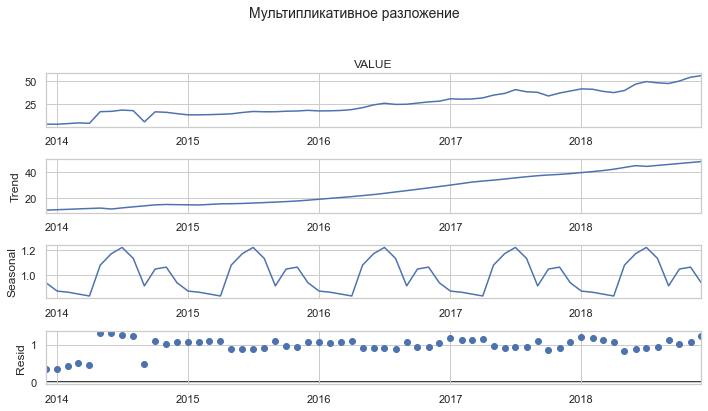

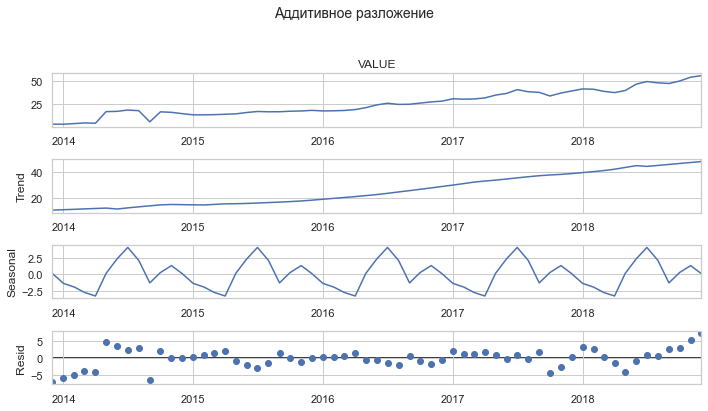

In [13]:
multiplicative_decomposition = seasonal_decompose(train_data['VALUE'], model='multiplicative', extrapolate_trend='freq')

additive_decomposition = seasonal_decompose(train_data['VALUE'], model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (10, 6)})

multiplicative_decomposition.plot().suptitle('Мультипликативное разложение', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Аддитивное разложение', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

На полученных графиках наблюдается годичная сезонность, которую в дальнейшем можно будет учесть при построении модели.

Большинство статистических методов прогнозирования работают только со стационарными рядами. Проведём тест Дики-Фуллера для проверки ряда на стационарность. Зафиксируем уровень значимости $\alpha = 0.05$

In [14]:
ad_fuller_result = adfuller(train_data['VALUE'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.1585666525994516
p-value: 0.9698395988921636


Полученное значение p-value больше 0.05, из-за чего мы отбрасываем нулевую гипотезу о стационарности ряда. Попробуем продифференцировать ряд (вычтем из каждого значения предыдущее).

In [15]:
train_data['DIFF'] = train_data['VALUE'].diff()

restored = train_data.copy()

train_data = train_data.dropna()

ad_fuller_result = adfuller(train_data['DIFF'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -5.830649702611667
p-value: 3.982537955181996e-07


Полученное значение p-value говорит о том, что с помощью дифференцирования удалось привести ряд к стационарному. Из этого следует, что для модели ARIMA возьмём значение параметра d = 1.

Посмотрим на график полученного ряда

Text(0.5, 1.0, 'График продифференцированного ряда')

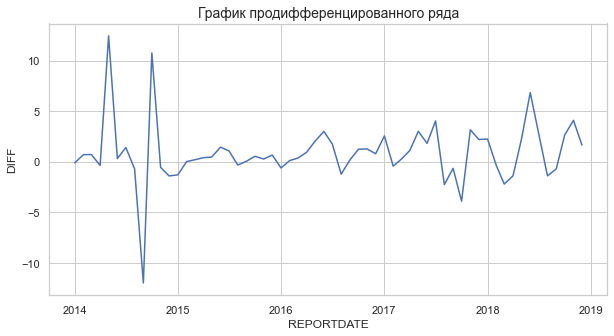

In [16]:
fig = plt.figure()
fig.set_size_inches(10, 5)

sns.lineplot(train_data.index, train_data['DIFF'])

plt.title('График продифференцированного ряда', fontsize=14)

Из представленного графика видно, что нам удалось избавиться от тренда и сделать ряд стационарным.

Посмотрим на графики автокоррелляции (ACF) и частичной автокорреляции (PACF)

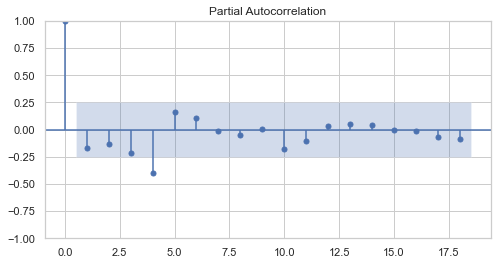

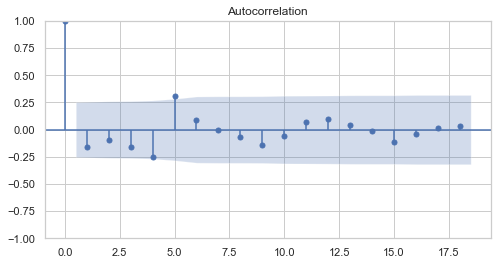

In [17]:
plt.rcParams.update({'figure.figsize': (8, 4)})

plot_pacf(train_data['DIFF']);
plot_acf(train_data['DIFF']);

С помощью полученных графиков можно определить границы области значений параметров модели ARIMA. По графику PACF возьмём максимальное значение p равным 4, а по графику ACF - максимальное значение q = 5. Кроме того, заметной сезонности в данных не наблюдается.

## ARIMA

Рассмотрим несколько моделей ARIMА с помощью функции `auto_arima()` из библиотеки `pmdarima`

In [18]:
model = pm.auto_arima(train_data['VALUE'], start_p=0, start_q=0,
                      test='adf',       
                      max_p=4, max_q=5, 
                      m=1,              
                      d=1, D=0,           
                      seasonal=False,   
                      start_P=0,  
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=306.037, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=306.454, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=305.670, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=308.571, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=303.507, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=305.360, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=305.411, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=304.513, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=307.534, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=303.166, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=304.143, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=306.208, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=306.045, Time=0.10 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=301.748, 

Посмотрим на параметры и анализ остатков лучшей модели

In [19]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   60
Model:               SARIMAX(2, 1, 4)   Log Likelihood                -142.850
Date:                Tue, 16 Aug 2022   AIC                            301.701
Time:                        11:41:36   BIC                            318.321
Sample:                             0   HQIC                           308.189
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8668      0.296      2.924      0.003       0.286       1.448
ar.L1          1.0166      0.046     21.870      0.000       0.926       1.108
ar.L2         -0.9953      0.035    -28.678      0.0

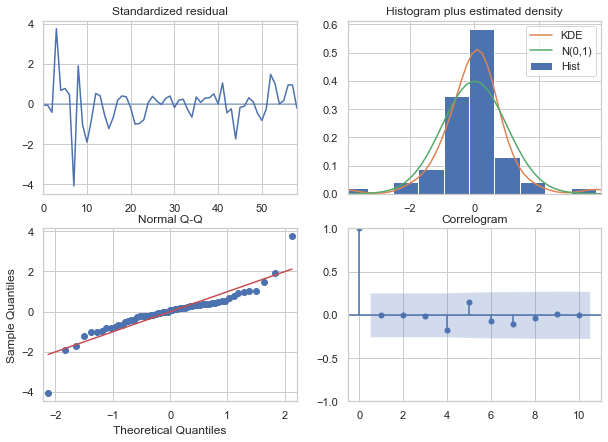

In [20]:
model.plot_diagnostics(figsize=(10, 7))
plt.show()

Видно, что полученные остатки не идеально ложатся на нормальное распределение со средним 0 и дисперсией 1, однако в них не наблюдается заметной автокорреляции. 

Попробуем построить прогноз полученной модели на тестовый период. Серым цветом отметим доверительный интервал. В качестве метрики возьмём RMSE.

rmse=2.5549885265417016


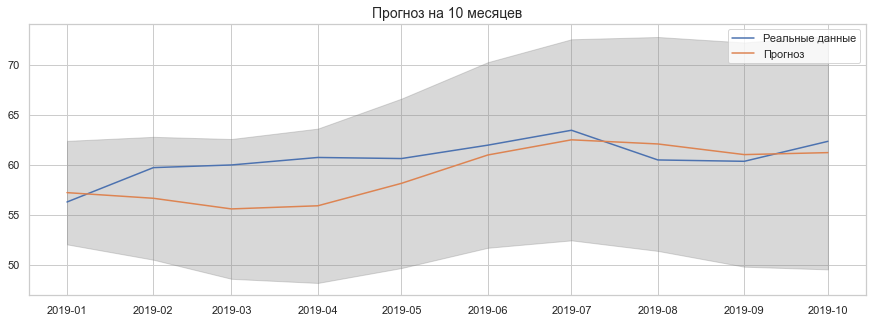

In [21]:
def metrics(forecast, actual):
    rmse = (np.mean((forecast - actual) ** 2)) ** 0.5
    
    return rmse


def quantile_forecast(model, n_periods):
    n_periods = n_periods

    preds, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    preds_series = pd.Series(preds, index=test_data.index[:n_periods])

    cf= pd.DataFrame(confint)
    
    rmse = metrics(preds, test_data['VALUE'][:n_periods])
    
    print(f'rmse={rmse}')

    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    ax.plot(test_data['VALUE'][:n_periods], label='Реальные данные')
    ax.plot(preds_series, label='Прогноз')
    ax.fill_between(preds_series.index,
                    cf[0],
                    cf[1], color='grey', alpha=.3)
    
    if n_periods == 1:
        month = 'месяц'
    elif n_periods in (2, 3, 4):
        month = 'месяца'
    else:
        month = 'месяцев'
    
    plt.title(f'Прогноз на {n_periods} {month}', fontsize=14)
    plt.legend()
    plt.show()
    
quantile_forecast(model, 10)

Посмотрим, как выглядит прогноз на графике с исходными данными. В качестве стабильной части за период будем брать минимальное из предсказанных значений. Для того, чтобы задать нужный период в месяцах воспользуемся модулем `dateutil.relativedelta`

In [23]:
def get_forecast(model, month_num):
    preds = model.predict(n_periods=month_num)
    
    return min(preds)

def visualize_forecast(model, start_date, n_periods):
    fig = plt.figure()
    fig.set_size_inches(10, 5)

    end_date = start_date + relativedelta(months=+n_periods)

    forecast = get_forecast(model, n_periods)

    plt.plot(daily_data[start_date: end_date].index, 
             daily_data[start_date: end_date]['VALUE'] * 10 ** 9, 
             label='Реальные данные')

    plt.axhline(y=forecast * 10 ** 9, color='red', label='Прогноз')
    
    if n_periods == 1:
        month = 'месяц'
    elif n_periods in (2, 3, 4):
        month = 'месяца'
    else:
        month = 'месяцев'
    
    plt.title(f'Прогноз на {n_periods} {month}', fontsize=14)

    plt.xlim(start_date, end_date)
    plt.legend()
    plt.show()

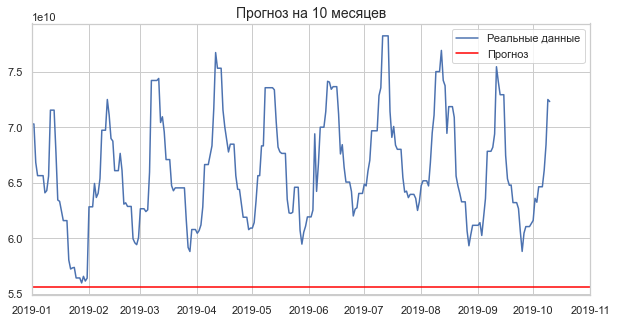

In [24]:
visualize_forecast(model, datetime(year=2019, month=1, day=1), 10)

## SARIMA

Попробуем учесть годичную сезонность данных, отмеченную в EDA. Для этого воспользуемся той же функцией `auto_arima`, только изменим период `m = 12` и `seasonal = True`

In [25]:
smodel = pm.auto_arima(train_data['VALUE'], start_p=0, start_q=0,
                       test='adf',
                       max_p=4, max_q=5, 
                       m=12,
                       d=1, D=1,
                       start_P=0, 
                       seasonal=True,
                       trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=251.350, Time=0.06 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=250.734, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=248.710, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=248.245, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=248.473, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=249.868, Time=0.27 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=250.100, Time=0.15 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=247.906, Time=0.04 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=249.886, Time=0.17 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=0.90 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=250.947, Time=0.04 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=249.658, Time=0.09 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=249.742, Time=0.06 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=251.372, Time=0.15 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   

Посмотрим на параметры и анализ остатков лучшей модели.

In [26]:
print(smodel.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   60
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                -120.953
Date:                             Tue, 16 Aug 2022   AIC                            247.906
Time:                                     11:43:59   BIC                            253.457
Sample:                                          0   HQIC                           249.995
                                              - 60                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3583      0.136     -2.642      0.008      -0.624      -0.093
ar.S.L12      -0.3640      

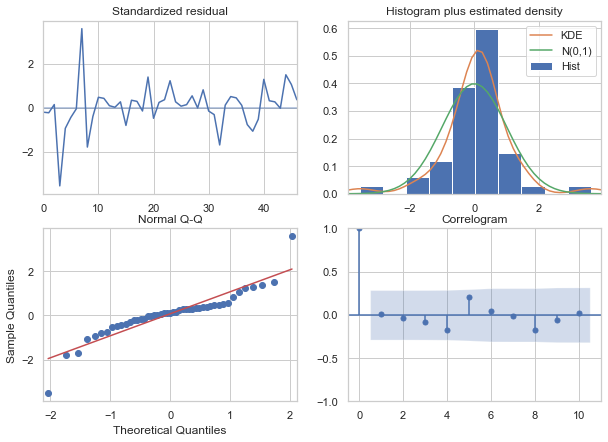

In [27]:
smodel.plot_diagnostics(figsize=(10, 7))
plt.show()

Заметим, что значение AIC уменьшилось по сравнению с лучшей моделью ARIMA, однако ситуация с остатками аналогичная.

Построим прогноз для тестовых данных.

rmse=3.163772201525823


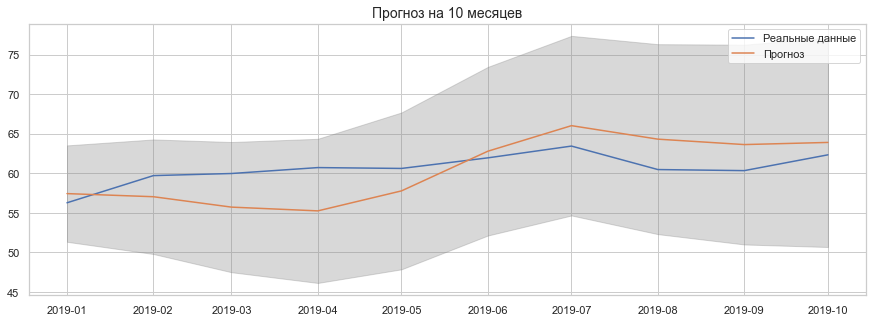

In [28]:
quantile_forecast(smodel, 10)

Полученное значение RMSE больше, чем у лучшей модели ARIMA. 

Построим прогнозы обеих моделей на периоды от 1 до 10 месяцев и посчитаем RMSE.

In [29]:
rmses = []
srmses = []

for i in range(1, test_data.shape[0] + 1):
    n_periods = i
    
    preds = model.predict(n_periods=n_periods, return_conf_int=False)
    spreds = smodel.predict(n_periods=n_periods, return_conf_int=False)
    
    rmse = metrics(preds, test_data['VALUE'][:n_periods])
    srmse = metrics(spreds, test_data['VALUE'][:n_periods])
    
    rmses.append(rmse)
    
    srmses.append(srmse)

Text(0, 0.5, 'RMSE')

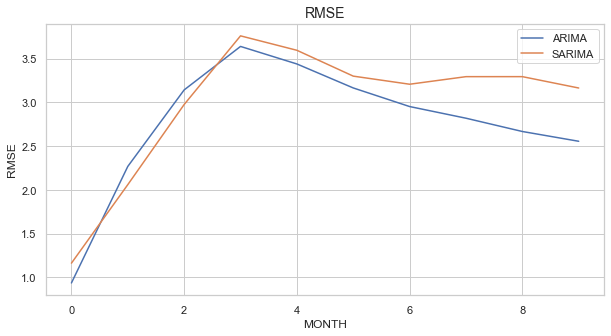

In [30]:
fig = plt.figure()
fig.set_size_inches(10, 5)

plt.plot(rmses, label='ARIMA')
plt.plot(srmses, label='SARIMA')

plt.legend()
plt.title('RMSE', fontsize=14)
plt.xlabel('MONTH')
plt.ylabel('RMSE')

Из полученных зависимостей видно, что хоть на коротких временных промежутках SARIMA и показывает себя чуть лучше, но в большинстве случаев качество лучше у ARIMA, поэтому её будем использовать в качестве финальной модели.

## Финальная модель

In [31]:
def model_forecast(start_date, num_periods, history_inp=None, visualize=False):
    
    start_date = parser.parse(start_date)   
    n_periods = int(re.findall('\d+', num_periods)[0])
    
    if history_inp is None:
        flag = 'test'
        history = data.set_index('REPORTDATE')[:start_date]
        daily_history = daily_data[:start_date]
    else:
        flag = 'prod'
        history = history_inp.copy()
        history['REPORTDATE'] = history['REPORTDATE'].apply(lambda x: x.replace('.', '/'))
        history['REPORTDATE'] = pd.to_datetime(history['REPORTDATE'], dayfirst=True)
        history['VALUE'] = history['VALUE'] * 10 ** (-9)
        
        history = history.set_index('REPORTDATE')
        history = history.resample('MS').apply(get_quantile)
        
        
    model = pm.auto_arima(history['VALUE'], start_p=0, start_q=0,
                      test='adf',       
                      max_p=4, max_q=5, 
                      m=1,              
                      d=1, D=0,           
                      seasonal=False,   
                      start_P=0,  
                      trace=False,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    
    forecast = get_forecast(model, n_periods)
    
    if visualize:
        if flag == 'test':
            visualize_forecast(model, start_date, n_periods)
        else:
            print("Не можем визуализировать без тестовых данных")
        
    
    return int(forecast * 10 ** 9)

Протестируем на нескольких других датах и горизонтах прогноза

In [32]:
model_forecast('2015-02-01', '3M')

13402156607

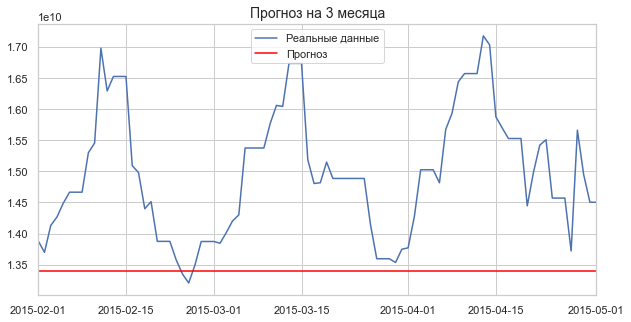

13402156607

In [33]:
model_forecast('2015-02-01', '3M', visualize=True)

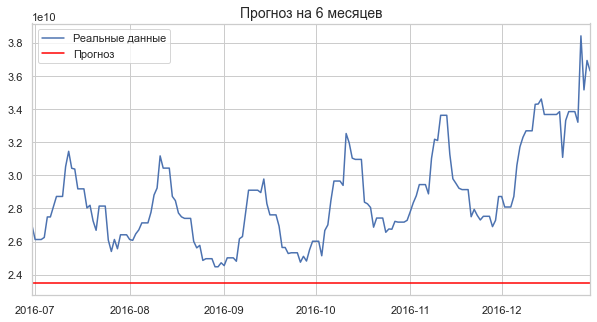

23502644094

In [34]:
model_forecast('2016-06-30', '6M', visualize=True)

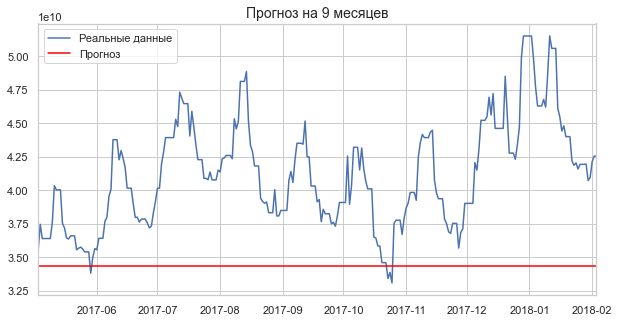

34370944747

In [35]:
model_forecast('2017-05-03', '9M', visualize=True)

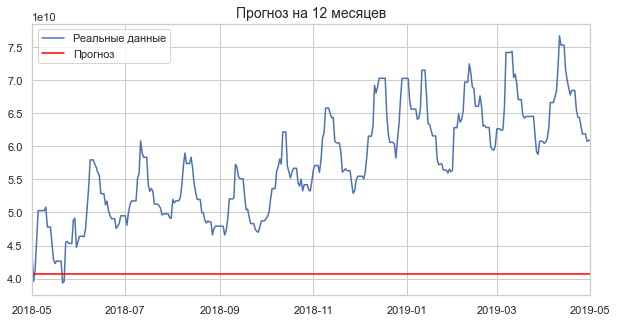

40676180520

In [36]:
model_forecast('2018-05-01', '12M', visualize=True)

Видно, что где-то модель справляется лучше, где-то хуже, но в целом получили неплохое качество прогноза.

Теперь протестируем формат, в котором будут приходить входные данные

In [37]:
history = pd.read_csv('data.csv', sep=';')

history = history[-150:]

history.tail()

,REPORTDATE,VALUE
2106,06.10.2019,64630140507
2107,07.10.2019,66115288637
2108,08.10.2019,68424049766
2109,09.10.2019,72492897583
2110,10.10.2019,72307860851


In [38]:
start_date = '2019-10-10'

In [39]:
model_forecast(start_date, '2M', history)

62335419879

In [40]:
model_forecast(start_date, '2M', history, visualize=True)

Не можем визуализировать без тестовых данных


62335419879